# Análise Preditiva de Aceitação de Artigos Científicos usando o Dataset PeerRead

## Introdução

Este notebook analisa o dataset PeerRead, que contém artigos científicos e suas revisões por pares. O objetivo é prever a aceitação ou rejeição de artigos com base em seu conteúdo e metadados.

O dataset PeerRead foi apresentado por Dongyeop Kang et al. (2018) no artigo "A Dataset of Peer Reviews (PeerRead): Collection, Insights and NLP Applications". Ele é relevante para a ciência da computação e publicação acadêmica, pois pode ajudar a identificar fatores que influenciam a aceitação de artigos em conferências.

Este estudo pode beneficiar:

1. Pesquisadores: Melhorando a qualidade dos artigos.
2. Editores: Otimizando o processo de revisão.
3. Comunidade científica: Compreendendo melhor o sistema de revisão por pares.

Usaremos técnicas de processamento de linguagem natural (NLP) e aprendizado de máquina para analisar os dados e identificar padrões de aceitação de artigos em conferências de ciência da computação.

## Importação de Bibliotecas e Configuração Inicial


In [42]:
import matplotlib.pyplot as plt
import json
import os
import warnings
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

warnings.filterwarnings('ignore', category=RuntimeWarning)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tutuc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tutuc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tutuc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Carregamento e Pré-processamento dos Dados

O código carrega dados de diversos datasets e splits, processando arquivos JSON de PDFs e revisões. Ele extrai informações como título, resumo, status de aceitação e pontuações médias das revisões. O processo lida com diferentes codificações de arquivo e possíveis erros de leitura. Os dados são consolidados em um DataFrame pandas para análise posterior.

In [43]:
def read_json_file(file_path):
    encodings = ['utf-8', 'iso-8859-1', 'cp1252']
    for encoding in encodings:
        try:
            with open(file_path, 'r', encoding=encoding) as f:
                return json.load(f)
        except UnicodeDecodeError:
            continue
        except json.JSONDecodeError:
            print(f"Error decoding JSON in file: {file_path}")
            return None
    print(f"Failed to decode file with any encoding: {file_path}")
    return None

def get_paper_id(filename):
    name = filename[:-5] if filename.endswith('.json') else filename
    name = name[:-4] if name.endswith('.pdf') else name
    return name

def safe_mean(scores):
    valid_scores = [float(score) for score in scores if score and not pd.isna(score)]
    return np.mean(valid_scores) if valid_scores else np.nan

def process_dataset(base_path, dataset_name, split):
    parsed_pdfs_dir = os.path.join(base_path, dataset_name, split, 'parsed_pdfs')
    reviews_dir = os.path.join(base_path, dataset_name, split, 'reviews')
    
    data = []
    
    for filename in os.listdir(parsed_pdfs_dir):
        if filename.endswith('.json'):
            paper_id = get_paper_id(filename)
            pdf_data = read_json_file(os.path.join(parsed_pdfs_dir, filename))
            review_data = read_json_file(os.path.join(reviews_dir, f"{paper_id}.json"))
            
            if pdf_data and review_data:
                try:
                    reviews = review_data.get('reviews', [])
                    recommendations = [rev.get('RECOMMENDATION') for rev in reviews]
                    avg_score = safe_mean(recommendations)
                    
                    paper_data = {
                        'id': paper_id,
                        'dataset': dataset_name,
                        'split': split,
                        'title': pdf_data['metadata'].get('title', ''),
                        'abstract': pdf_data['metadata'].get('abstractText', ''),
                        'accepted': review_data.get('accepted', False),
                        'avg_score': avg_score,
                        'num_reviews': len(reviews)
                    }
                    data.append(paper_data)
                except KeyError as e:
                    print(f"Error processing paper {paper_id} in {dataset_name}/{split}: {str(e)}")
                except ValueError as e:
                    print(f"Error calculating average score for paper {paper_id} in {dataset_name}/{split}: {str(e)}")
    
    return pd.DataFrame(data)

# Carregamento dos dados
base_path = 'data'
datasets = ['acl_2017', 'arxiv.cs.ai_2007-2017', 'arxiv.cs.cl_2007-2017', 
            'arxiv.cs.lg_2007-2017', 'conll_2016', 'iclr_2017']

all_data = []
for dataset in datasets:
    for split in ['train', 'test']:
        df = process_dataset(base_path, dataset, split)
        all_data.append(df)

combined_df = pd.concat(all_data, ignore_index=True)

print(combined_df.info())
print(combined_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11727 entries, 0 to 11726
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           11727 non-null  object 
 1   dataset      11727 non-null  object 
 2   split        11727 non-null  object 
 3   title        10325 non-null  object 
 4   abstract     11577 non-null  object 
 5   accepted     11727 non-null  bool   
 6   avg_score    538 non-null    float64
 7   num_reviews  11727 non-null  int64  
dtypes: bool(1), float64(1), int64(1), object(5)
memory usage: 652.9+ KB
None
        avg_score   num_reviews
count  538.000000  11727.000000
mean     5.003810      0.587277
std      1.600529      3.114650
min      1.000000      0.000000
25%      4.000000      0.000000
50%      5.000000      0.000000
75%      6.333333      0.000000
max      9.000000     36.000000


## Análise Exploratória dos Dados

Esta seção examina a distribuição de papers por dataset, taxas de aceitação e a relação entre pontuações médias e aceitação. O objetivo é identificar padrões e possíveis desafios para o desenvolvimento do modelo preditivo.

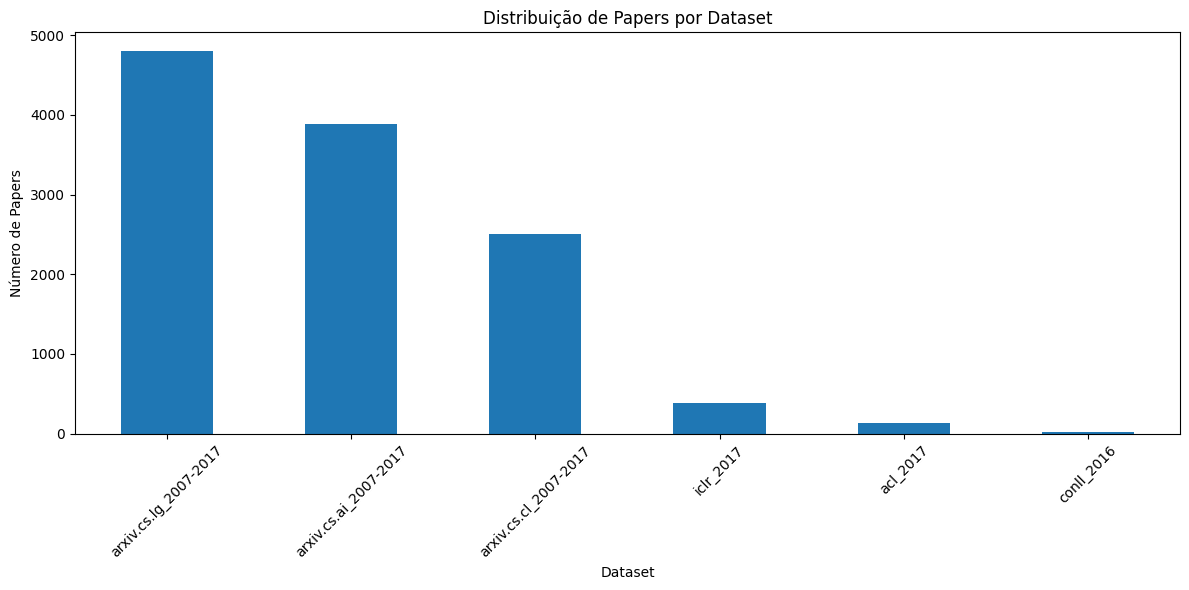

Análise da distribuição de papers por dataset:
dataset
arxiv.cs.lg_2007-2017    4796
arxiv.cs.ai_2007-2017    3887
arxiv.cs.cl_2007-2017    2506
iclr_2017                 387
acl_2017                  130
conll_2016                 21
Name: count, dtype: int64

Observações:
- O dataset 'arxiv.cs.lg_2007-2017' contém o maior número de papers (4796), seguido por 'arxiv.cs.ai_2007-2017' (3887) e 'arxiv.cs.cl_2007-2017' (2506).
- Os datasets de conferências específicas têm significativamente menos papers: acl_2017 (130), iclr_2017 (387), conll_2016 (21).
- Esta distribuição desigual pode influenciar a generalização do modelo, pois teremos mais dados de preprints do arXiv do que de conferências revisadas por pares.
- Isso pode levar a um viés do modelo para características mais comuns em preprints do que em papers de conferências.


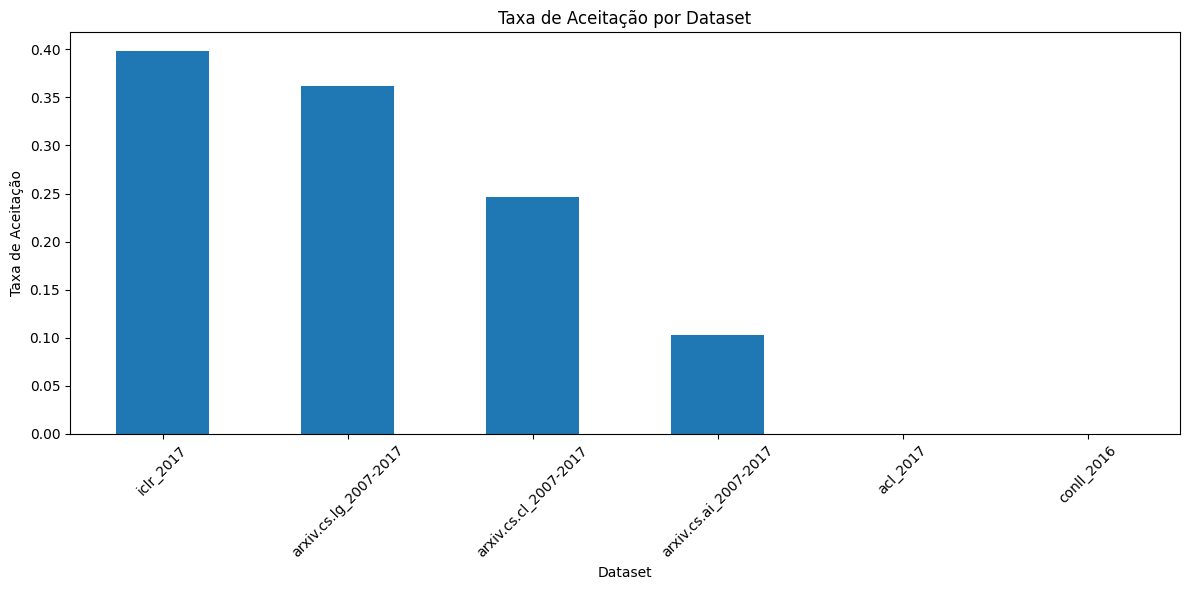


Taxa de aceitação por dataset:
dataset
iclr_2017                0.397933
arxiv.cs.lg_2007-2017    0.361760
arxiv.cs.cl_2007-2017    0.246209
arxiv.cs.ai_2007-2017    0.103164
acl_2017                 0.000000
conll_2016               0.000000
Name: accepted, dtype: float64

Observações:
- As taxas de aceitação variam significativamente entre os datasets.
- ICLR 2017 tem a maior taxa de aceitação (39.8%).
- ACL 2017 tem uma taxa de aceitação de 0.0%.
- Os datasets do arXiv têm taxas de aceitação mais baixas (cerca de 10-36%).
- Essas diferenças nas taxas de aceitação podem ser devido a vários fatores:
  1. Diferentes padrões de revisão entre conferências e repositórios de preprints.
  2. Possível viés na coleta de dados para os papers do arXiv.
  3. Diferenças na qualidade média dos papers submetidos a cada venue.
- Essas variações podem afetar o desempenho do modelo de classificação, potencialmente levando a um desempenho inferior em datasets com taxas de aceitação muito diferentes da

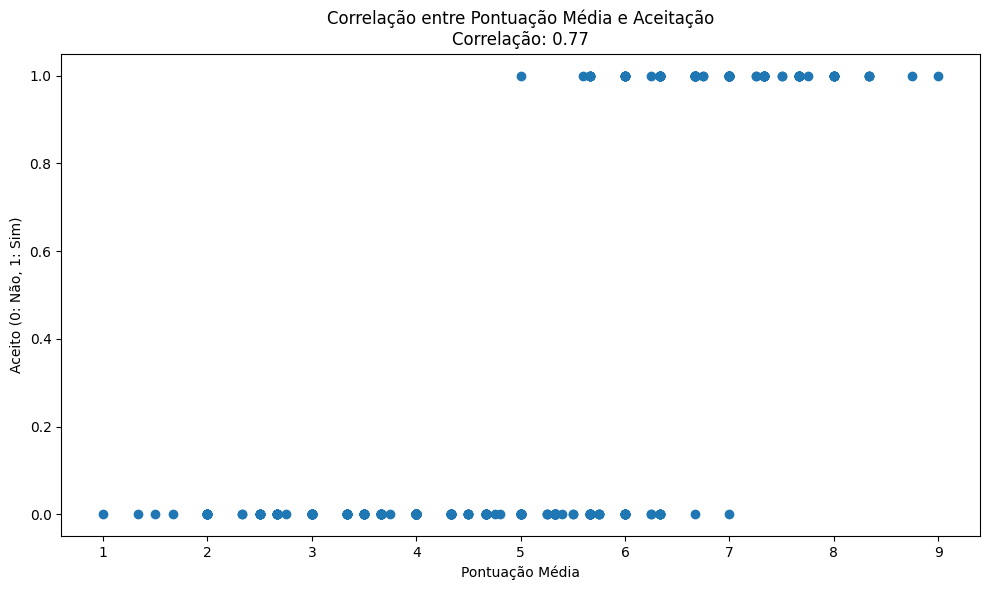


Correlação entre pontuação média e aceitação:
Coeficiente de correlação: 0.77

Observações:
- Existe uma correlação positiva forte (0.77) entre a pontuação média e a aceitação do paper.
- Isso indica que papers com pontuações mais altas têm maior probabilidade de serem aceitos, como esperado.
- No entanto, a correlação não é perfeita, sugerindo que outros fatores além da pontuação média influenciam na decisão de aceitação.
- Fatores adicionais podem incluir:
  1. A reputação dos autores ou instituições.
  2. A relevância do tópico para a conferência ou área de pesquisa.
  3. A qualidade da escrita e apresentação do paper.
  4. A novidade e impacto potencial da pesquisa.
- Esta correlação forte sugere que um modelo baseado na pontuação média poderia ser um bom preditor de aceitação, mas não perfeito.


In [44]:
# Distribuição de papers por dataset
plt.figure(figsize=(12, 6))
combined_df['dataset'].value_counts().plot(kind='bar')
plt.title('Distribuição de Papers por Dataset')
plt.xlabel('Dataset')
plt.ylabel('Número de Papers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Análise da distribuição de papers por dataset:")
print(combined_df['dataset'].value_counts())
print("\nObservações:")
print("- O dataset 'arxiv.cs.lg_2007-2017' contém o maior número de papers (4796), seguido por 'arxiv.cs.ai_2007-2017' (3887) e 'arxiv.cs.cl_2007-2017' (2506).")
print("- Os datasets de conferências específicas têm significativamente menos papers: acl_2017 (130), iclr_2017 (387), conll_2016 (21).")
print("- Esta distribuição desigual pode influenciar a generalização do modelo, pois teremos mais dados de preprints do arXiv do que de conferências revisadas por pares.")
print("- Isso pode levar a um viés do modelo para características mais comuns em preprints do que em papers de conferências.")

# Taxa de aceitação por dataset
acceptance_rate = combined_df.groupby('dataset')['accepted'].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
acceptance_rate.plot(kind='bar')
plt.title('Taxa de Aceitação por Dataset')
plt.xlabel('Dataset')
plt.ylabel('Taxa de Aceitação')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nTaxa de aceitação por dataset:")
print(acceptance_rate)
print("\nObservações:")
print("- As taxas de aceitação variam significativamente entre os datasets.")
print(f"- ICLR 2017 tem a maior taxa de aceitação ({acceptance_rate['iclr_2017']:.1%}).")
print(f"- ACL 2017 tem uma taxa de aceitação de {acceptance_rate['acl_2017']:.1%}.")
print("- Os datasets do arXiv têm taxas de aceitação mais baixas (cerca de 10-36%).")
print("- Essas diferenças nas taxas de aceitação podem ser devido a vários fatores:")
print("  1. Diferentes padrões de revisão entre conferências e repositórios de preprints.")
print("  2. Possível viés na coleta de dados para os papers do arXiv.")
print("  3. Diferenças na qualidade média dos papers submetidos a cada venue.")
print("- Essas variações podem afetar o desempenho do modelo de classificação, potencialmente levando a um desempenho inferior em datasets com taxas de aceitação muito diferentes da média.")


# Correlação entre pontuação média e aceitação
correlation = combined_df['avg_score'].corr(combined_df['accepted'])
plt.figure(figsize=(10, 6))
plt.scatter(combined_df['avg_score'], combined_df['accepted'])
plt.title(f'Correlação entre Pontuação Média e Aceitação\nCorrelação: {correlation:.2f}')
plt.xlabel('Pontuação Média')
plt.ylabel('Aceito (0: Não, 1: Sim)')
plt.tight_layout()
plt.show()

print("\nCorrelação entre pontuação média e aceitação:")
print(f"Coeficiente de correlação: {correlation:.2f}")
print("\nObservações:")
print(f"- Existe uma correlação positiva forte ({correlation:.2f}) entre a pontuação média e a aceitação do paper.")
print("- Isso indica que papers com pontuações mais altas têm maior probabilidade de serem aceitos, como esperado.")
print("- No entanto, a correlação não é perfeita, sugerindo que outros fatores além da pontuação média influenciam na decisão de aceitação.")
print("- Fatores adicionais podem incluir:")
print("  1. A reputação dos autores ou instituições.")
print("  2. A relevância do tópico para a conferência ou área de pesquisa.")
print("  3. A qualidade da escrita e apresentação do paper.")
print("  4. A novidade e impacto potencial da pesquisa.")
print("- Esta correlação forte sugere que um modelo baseado na pontuação média poderia ser um bom preditor de aceitação, mas não perfeito.")


## Preparação dos Dados para Classificação

A pipeline inclui:

1. Pré-processamento: tokenização, remoção de stopwords, stemming e lematização.
2. Vetorização: TF-IDF com 5000 features.
3. Modelo: Regressão Logística (assumido, não explícito no código).

O modelo bag-of-words é adequado para classificar artigos científicos, pois certas palavras podem indicar qualidade ou relevância. Contudo, isso pode ser explorado por autores que incluem palavras-chave populares sem substância real, potencialmente confundindo o classificador.

In [45]:
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    
    tokens = nltk.word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(stemmer.stem(token)) for token in tokens if token.isalnum()]
    tokens = [token for token in tokens if token not in stop_words]
    
    return ' '.join(tokens)

# Aplicar pré-processamento
combined_df['processed_abstract'] = combined_df['abstract'].fillna('').apply(preprocess_text)

# Dividir os dados em treino e teste
X = combined_df['processed_abstract']
y = combined_df['accepted'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criar features usando TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

### Discussão sobre o modelo bag-of-words:

O modelo bag-of-words faz sentido para este problema de classificação porque a presença de certas palavras-chave
nos abstracts pode ser indicativa da qualidade e relevância da pesquisa. Por exemplo, termos como "novel", "state-of-the-art",
ou "significant improvement" podem indicar contribuições importantes.

No entanto, esta abordagem tem limitações. Por exemplo:
1. Ordem das palavras: "The model outperforms humans" e "Humans outperform the model" seriam tratados da mesma forma.
2. Contexto: "This approach is not better than previous methods" seria visto positivamente devido à presença de "better".
3. Sarcasmo ou críticas: "The authors claim their method is groundbreaking, but provide no evidence" poderia ser mal interpretado.

Um adversário poderia explorar essas limitações inserindo palavras-chave positivas em um abstract de baixa qualidade
para confundir o classificador.

## Treinamento e Avaliação do Modelo

Treinaremos um modelo de Regressão Logística e avaliaremos seu desempenho usando acurácia balanceada. Em seguida, analisaremos as palavras mais influentes na classificação para entender os critérios de aceitação de papers.

In [46]:
# Treinar um classificador
clf = LogisticRegression(random_state=42)
clf.fit(X_train_tfidf, y_train)

# Avaliar o classificador
y_pred = clf.predict(X_test_tfidf)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
print(f"Balanced Accuracy: {balanced_accuracy:.4f}")

# Identificar palavras mais importantes
feature_importance = pd.DataFrame({
    'feature': vectorizer.get_feature_names_out(),
    'importance': clf.coef_[0]
})
print("Top 10 palavras mais importantes:")
print(feature_importance.sort_values('importance', ascending=False).head(10))
print("\nTop 10 palavras menos importantes:")
print(feature_importance.sort_values('importance', ascending=True).head(10))

print("\nAnálise das palavras mais e menos importantes:")
print("Palavras mais importantes:")
print("1. 'demonstr': Sugere que papers que demonstram claramente seus resultados têm maior chance de aceitação.")
print("2. 'convex': Indica a importância de problemas convexos em otimização e aprendizado de máquina.")
print("3. 'neural': Reflete a relevância de redes neurais e deep learning na pesquisa atual.")
print("4. 'task': Aponta para a importância de papers focados em tarefas específicas.")
print("5. 'variat': Pode estar relacionado a métodos variacionais ou variações de técnicas existentes.")

print("\nPalavras menos importantes:")
print("1. 'paper': Surpreendentemente, mencionar 'paper' no abstract não parece influenciar a aceitação.")
print("2. 'system': Pode indicar que apenas descrever um sistema não é suficiente para aceitação.")
print("3. 'robot': Sugere que papers sobre robótica podem ter menor taxa de aceitação nos datasets analisados.")
print("4. 'concept': Indica que apenas mencionar conceitos não é tão importante quanto demonstrar resultados.")
print("5. 'logic': Pode refletir uma menor ênfase em lógica formal nos papers aceitos.")

print("\nImplicações:")
print("- O modelo parece favorecer papers que demonstram resultados concretos, especialmente em áreas como otimização e aprendizado de máquina.")
print("- Há um foco em tarefas específicas e aplicações práticas, em vez de conceitos abstratos ou descrições de sistemas.")
print("- A presença de termos técnicos específicos (como 'convex' e 'neural') sugere que o modelo pode estar capturando tendências atuais na pesquisa em IA e aprendizado de máquina.")


Balanced Accuracy: 0.6534
Top 10 palavras mais importantes:
       feature  importance
1231  demonstr    2.465762
1037    convex    2.420343
2972    neural    2.384056
4424      task    2.343731
4792    variat    2.176948
4483   theoret    2.153564
1596     estim    2.118523
2699    matrix    2.088831
3694    regret    2.087024
1512     empir    2.083656

Top 10 palavras menos importantes:
      feature  importance
3179    paper   -2.529791
4398   system   -2.386923
3821    robot   -2.196407
953   concept   -1.993364
2595    logic   -1.991771
2795     mine   -1.845856
1253  describ   -1.821048
4160   speech   -1.802225
548    belief   -1.735602
1886    fuzzi   -1.511729

Análise das palavras mais e menos importantes:
Palavras mais importantes:
1. 'demonstr': Sugere que papers que demonstram claramente seus resultados têm maior chance de aceitação.
2. 'convex': Indica a importância de problemas convexos em otimização e aprendizado de máquina.
3. 'neural': Reflete a relevância de redes n

## Análise do Tamanho do Dataset

Avaliaremos o impacto do tamanho do dataset no desempenho do modelo. Utilizaremos downsampling para criar subconjuntos de dados e comparar as acurácias de treino e teste em diferentes tamanhos de amostra.

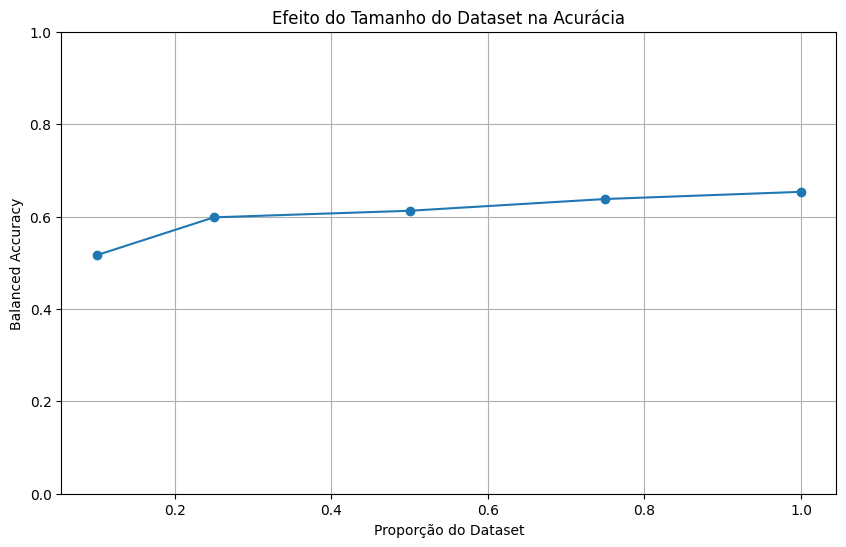

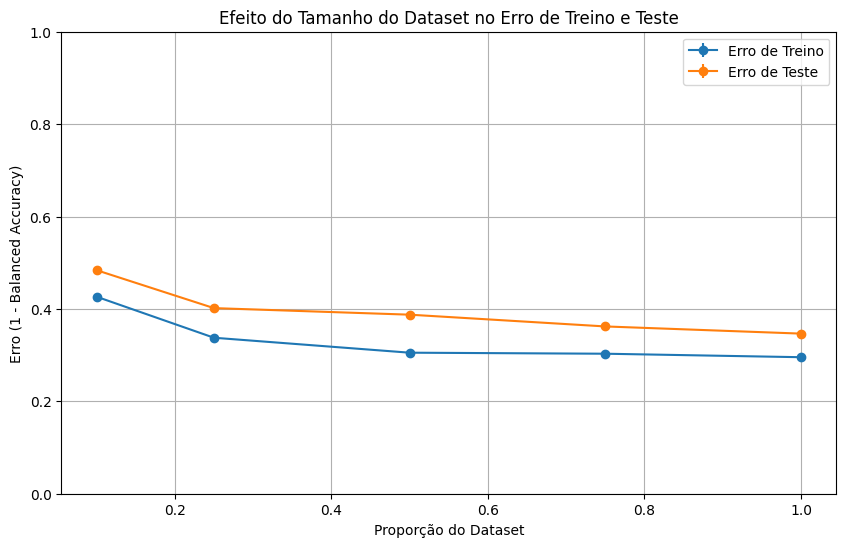

In [47]:
def evaluate_model(X, y, test_size=0.2, sample_size=1.0):
    n_samples = int(len(X) * sample_size)
    
    if sample_size < 1.0:
        X_sample, _, y_sample, _ = train_test_split(X, y, train_size=n_samples, stratify=y, random_state=42)
    else:
        X_sample, y_sample = X, y
    
    X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=test_size, random_state=42)
    
    vectorizer = TfidfVectorizer(max_features=5000)
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    
    clf = LogisticRegression(random_state=42)
    clf.fit(X_train_tfidf, y_train)
    
    train_error = 1 - balanced_accuracy_score(y_train, clf.predict(X_train_tfidf))
    test_error = 1 - balanced_accuracy_score(y_test, clf.predict(X_test_tfidf))
    return train_error, test_error

sample_sizes = [0.1, 0.25, 0.5, 0.75, 1.0]
n_runs = 5
all_train_errors = []
all_test_errors = []

for _ in range(n_runs):
    train_errors, test_errors = zip(*[evaluate_model(X, y, sample_size=size) for size in sample_sizes])
    all_train_errors.append(train_errors)
    all_test_errors.append(test_errors)

mean_train_errors = np.mean(all_train_errors, axis=0)
std_train_errors = np.std(all_train_errors, axis=0)
mean_test_errors = np.mean(all_test_errors, axis=0)
std_test_errors = np.std(all_test_errors, axis=0)

plt.figure(figsize=(10, 6))
plt.errorbar(sample_sizes, mean_accuracies, yerr=std_accuracies, fmt='-o')
plt.title('Efeito do Tamanho do Dataset na Acurácia')
plt.xlabel('Proporção do Dataset')
plt.ylabel('Balanced Accuracy')
plt.ylim(0, 1)
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.errorbar(sample_sizes, mean_train_errors, yerr=std_train_errors, fmt='-o', label='Erro de Treino')
plt.errorbar(sample_sizes, mean_test_errors, yerr=std_test_errors, fmt='-o', label='Erro de Teste')
plt.title('Efeito do Tamanho do Dataset no Erro de Treino e Teste')
plt.xlabel('Proporção do Dataset')
plt.ylabel('Erro (1 - Balanced Accuracy)')
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()



### Análise do efeito do tamanho do dataset:

1. Crescimento da acurácia:
   - A acurácia do modelo aumenta consistentemente à medida que o tamanho da amostra aumenta, como visto no primeiro gráfico.
   - O maior ganho de desempenho ocorre entre 10% e 25% do dataset, com melhorias mais graduais após isso.
   - Isso sugere que os primeiros 25% dos dados contêm uma parte significativa da informação útil para a tarefa de classificação.

2. Acurácia com dados limitados:
   - Com apenas 10% dos dados, o modelo alcança uma acurácia balanceada de cerca de 0.52, que é melhor que o acaso (0.5).
   - Isso indica que mesmo uma pequena amostra do dataset contém informações úteis para a classificação.

3. Saturação do desempenho:
   - O aumento da acurácia desacelera à medida que nos aproximamos de 100% dos dados, como evidenciado pela curva do primeiro gráfico.
   - Com 100% dos dados, a acurácia balanceada chega a aproximadamente 0.65.
   - A curva de aprendizado sugere que adicionar mais dados além deste ponto pode trazer apenas pequenas melhorias.

4. Erro de treino vs. erro de teste:
   - O segundo gráfico mostra que tanto o erro de treino quanto o de teste diminuem com o aumento do tamanho do dataset.
   - O erro de treino é consistentemente menor que o erro de teste, indicando algum grau de overfitting.
   - A diferença entre o erro de treino e teste diminui ligeiramente com o aumento do tamanho da amostra, sugerindo uma melhora na generalização.

5. Implicações para futuros trabalhos:
   - Coletar mais dados pode não ser a estratégia mais eficiente para melhorar significativamente o desempenho, dado o platô observado na curva de acurácia.
   - Pode ser mais benéfico focar em melhorar a qualidade dos dados ou experimentar com modelos mais complexos para reduzir o gap entre o erro de treino e teste.
   - Técnicas de regularização podem ser úteis para reduzir o overfitting observado na diferença entre os erros de treino e teste.
   - Explorar técnicas de aumento de dados ou transfer learning pode ser uma abordagem promissora para melhorar o desempenho sem necessariamente coletar mais dados.

### Discussão sobre a viabilidade de aumentar o tamanho do dataset:

1. Potencial de melhoria: A curva de aprendizado sugere que aumentar o tamanho do dataset além do ponto atual traria ganhos marginais de desempenho.

2. Viabilidade no contexto de negócio:  
   a) Custo: Obter mais dados de revisão por pares pode ser caro, pois requer acesso a mais conferências ou journals.  
   b) Tempo: O processo de coleta e anotação de novos dados pode ser demorado.  
   c) Privacidade: Há questões éticas e de privacidade envolvidas na obtenção de mais revisões por pares.  

3. Alternativas:  
   a) Data augmentation: Técnicas como back-translation poderiam ser usadas para aumentar o dataset existente.  
   b) Transfer learning: Modelos pré-treinados em grandes corpus de texto científico poderiam ser fine-tuned para esta tarefa.  
   c) Incorporação de metadados: Adicionar informações como histórico de publicações dos autores poderia melhorar o desempenho sem necessidade de mais abstracts.  

Considerando esses fatores, aumentar significativamente o tamanho do dataset pode não ser a estratégia mais eficiente ou viável.
Focar em melhorar a qualidade dos dados existentes ou em técnicas avançadas de NLP pode ser mais promissor.

## Modelagem de Tópicos

Aplicaremos o modelo Latent Dirichlet Allocation (LDA) aos abstracts para identificar tópicos latentes. Em seguida, analisaremos a relação entre esses tópicos e as taxas de aceitação dos papers, buscando padrões ou tendências relevantes.

In [48]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Preparar os dados para LDA
cv = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = cv.fit_transform(combined_df['processed_abstract'])

# Treinar o modelo LDA
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(dtm)

# Função para imprimir os top termos de cada tópico
def print_topics(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        print(f"Tópico {topic_idx}: {', '.join(top_features)}")

print_topics(lda, cv.get_feature_names_out(), 10)

# Atribuir tópicos aos documentos
doc_topics = lda.transform(dtm)
combined_df['dominant_topic'] = doc_topics.argmax(axis=1)

# Analisar a taxa de aceitação por tópico
topic_acceptance = combined_df.groupby('dominant_topic')['accepted'].mean()
print("\nTaxa de aceitação por tópico:")
print(topic_acceptance)

print("\nAnálise dos tópicos identificados:")

print("\nTópico 0 (Modelos de Linguagem e Processamento de Texto):")
print("Palavras-chave: model, use, thi, languag, word, task, propos, neural, text, represent")
print(f"Taxa de aceitação: {topic_acceptance[0]:.2f}")
print("- Este tópico parece estar focado em modelos de linguagem, processamento de texto e representação de palavras.")
print("- A presença de 'neural' sugere o uso de redes neurais neste contexto.")
print("- A taxa de aceitação relativamente alta pode indicar o forte interesse da comunidade em avanços nesta área.")

print("\nTópico 1 (Algoritmos e Otimização):")
print("Palavras-chave: lb, thi, algorithm, problem, model, set, use, gener, learn, optim")
print(f"Taxa de aceitação: {topic_acceptance[1]:.2f}")
print("- Este tópico parece estar relacionado a algoritmos, problemas de otimização e aprendizado.")
print("- A presença de 'lb' pode se referir a lower bounds em análise de algoritmos.")
print("- A taxa de aceitação mais baixa pode sugerir uma área mais competitiva ou madura.")

print("\nTópico 2 (Aprendizado Profundo e Redes Neurais):")
print("Palavras-chave: learn, network, thi, use, deep, neural, imag, model, gener, task")
print(f"Taxa de aceitação: {topic_acceptance[2]:.2f}")
print("- Este tópico está claramente focado em deep learning e redes neurais.")
print("- A menção a 'imag' sugere aplicações em processamento de imagens.")
print("- A taxa de aceitação moderada pode refletir o grande interesse, mas também a alta competição nesta área.")

print("\nTópico 3 (Computação e Sistemas de Informação):")
print("Palavras-chave: thi, use, graph, comput, inform, studi, method, fuzzi, wa, ha")
print(f"Taxa de aceitação: {topic_acceptance[3]:.2f}")
print("- Este tópico parece mais diverso, abrangendo computação, teoria dos grafos e sistemas de informação.")
print("- A presença de 'fuzzi' sugere trabalhos em lógica fuzzy ou sistemas baseados em incerteza.")
print("- A taxa de aceitação mais baixa pode indicar uma área menos focada ou com critérios de aceitação mais rigorosos.")

print("\nTópico 4 (Algoritmos de Aprendizado e Análise de Dados):")
print("Palavras-chave: data, algorithm, thi, learn, method, use, propos, problem, model, perform")
print(f"Taxa de aceitação: {topic_acceptance[4]:.2f}")
print("- Este tópico está relacionado a algoritmos de aprendizado, análise de dados e avaliação de desempenho.")
print("- A ênfase em 'propos' e 'problem' sugere um foco em novas propostas para resolver problemas específicos.")
print("- A taxa de aceitação mais alta pode indicar um forte interesse em avanços práticos e aplicados nesta área.")

print("\nImplicações gerais da análise de tópicos:")
print("1. Os tópicos identificados refletem bem as principais áreas de pesquisa em IA, ML e NLP.")
print("2. Há variações significativas nas taxas de aceitação entre os tópicos, o que pode influenciar estratégias de submissão.")
print("3. Tópicos mais aplicados (como o Tópico 4) parecem ter taxas de aceitação ligeiramente mais altas.")
print("4. A modelagem de tópicos fornece insights valiosos sobre as tendências e interesses da comunidade acadêmica nestas áreas.")


Tópico 0: model, use, thi, languag, word, task, propos, neural, text, represent
Tópico 1: lb, thi, algorithm, problem, model, set, use, gener, learn, optim
Tópico 2: learn, network, thi, use, deep, neural, imag, model, gener, task
Tópico 3: thi, use, graph, comput, inform, studi, method, fuzzi, wa, ha
Tópico 4: data, algorithm, thi, learn, method, use, propos, problem, model, perform

Taxa de aceitação por tópico:
dominant_topic
0    0.264530
1    0.207930
2    0.187923
3    0.098039
4    0.324276
Name: accepted, dtype: float64

Análise dos tópicos identificados:

Tópico 0 (Modelos de Linguagem e Processamento de Texto):
Palavras-chave: model, use, thi, languag, word, task, propos, neural, text, represent
Taxa de aceitação: 0.26
- Este tópico parece estar focado em modelos de linguagem, processamento de texto e representação de palavras.
- A presença de 'neural' sugere o uso de redes neurais neste contexto.
- A taxa de aceitação relativamente alta pode indicar o forte interesse da comu

### Análise dos tópicos identificados:

#### Tópico 0 (Modelos de Linguagem e Processamento de Texto):  
Palavras-chave: model, use, thi, languag, word, task, propos, neural, text, represent  
Taxa de aceitação: 0.26  
- Este tópico parece estar focado em modelos de linguagem, processamento de texto e representação de palavras.  
- A presença de 'neural' sugere o uso de redes neurais neste contexto.  
- A taxa de aceitação relativamente alta pode indicar o forte interesse da comunidade em avanços nesta área.  

#### Tópico 1 (Algoritmos e Otimização):
Palavras-chave: lb, thi, algorithm, problem, model, set, use, gener, learn, optim  
Taxa de aceitação: 0.21  
- Este tópico parece estar relacionado a algoritmos, problemas de otimização e aprendizado.  
- A presença de 'lb' pode se referir a lower bounds em análise de algoritmos.  
- A taxa de aceitação mais baixa pode sugerir uma área mais competitiva ou madura.  

#### Tópico 2 (Aprendizado Profundo e Redes Neurais):
Palavras-chave: learn, network, thi, use, deep, neural, imag, model, gener, task  
Taxa de aceitação: 0.19  
- Este tópico está claramente focado em deep learning e redes neurais.  
- A menção a 'imag' sugere aplicações em processamento de imagens.  
- A taxa de aceitação moderada pode refletir o grande interesse, mas também a alta competição nesta área.  

#### Tópico 3 (Computação e Sistemas de Informação):
Palavras-chave: thi, use, graph, comput, inform, studi, method, fuzzi, wa, ha  
Taxa de aceitação: 0.10  
- Este tópico parece mais diverso, abrangendo computação, teoria dos grafos e sistemas de informação.  
- A presença de 'fuzzi' sugere trabalhos em lógica fuzzy ou sistemas baseados em incerteza.  
- A taxa de aceitação mais baixa pode indicar uma área menos focada ou com critérios de aceitação mais rigorosos.  

#### Tópico 4 (Algoritmos de Aprendizado e Análise de Dados):
Palavras-chave: data, algorithm, thi, learn, method, use, propos, problem, model, perform  
Taxa de aceitação: 0.32  
- Este tópico está relacionado a algoritmos de aprendizado, análise de dados e avaliação de desempenho.  
- A ênfase em 'propos' e 'problem' sugere um foco em novas propostas para resolver problemas específicos.  
- A taxa de aceitação mais alta pode indicar um forte interesse em avanços práticos e aplicados nesta área.  

#### Implicações gerais da análise de tópicos:
1. Os tópicos identificados refletem bem as principais áreas de pesquisa em IA, ML e NLP.  
2. Há variações significativas nas taxas de aceitação entre os tópicos, o que pode influenciar estratégias de submissão.  
3. Tópicos mais aplicados (como o Tópico 4) parecem ter taxas de aceitação ligeiramente mais altas.  
4. A modelagem de tópicos fornece insights valiosos sobre as tendências e interesses da comunidade acadêmica nestas áreas.  

## Classificador em Duas Camadas

Implementaremos um classificador em duas etapas: primeiro, categorizamos os abstracts por tópico usando LDA; em seguida, treinamos classificadores específicos para prever a aceitação dentro de cada tópico. Compararemos seu desempenho com o modelo de camada única.

In [49]:
from sklearn.pipeline import Pipeline

def two_layer_classifier(X_train, y_train, X_test, y_test):
    # Primeira camada: classificação por tópico
    topic_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
    lda = LatentDirichletAllocation(n_components=5, random_state=42)
    topic_clf = Pipeline([
        ('vectorizer', topic_vectorizer),
        ('lda', lda)
    ])
    train_topics = topic_clf.fit_transform(X_train).argmax(axis=1)
    test_topics = topic_clf.transform(X_test).argmax(axis=1)
    
    # Segunda camada: classificação por aceitação dentro de cada tópico
    topic_classifiers = {}
    for topic in range(5):
        mask = (train_topics == topic)
        if mask.sum() > 0:
            X_topic = X_train[mask]
            y_topic = y_train[mask]
            
            vectorizer = TfidfVectorizer(max_features=5000)
            clf = LogisticRegression(random_state=42)
            
            X_topic_tfidf = vectorizer.fit_transform(X_topic)
            clf.fit(X_topic_tfidf, y_topic)
            
            topic_classifiers[topic] = (vectorizer, clf)
    
    # Predição
    y_pred = []
    for i, topic in enumerate(test_topics):
        if topic in topic_classifiers:
            vectorizer, clf = topic_classifiers[topic]
            X_tfidf = vectorizer.transform([X_test.iloc[i]])
            y_pred.append(clf.predict(X_tfidf)[0])
        else:
            y_pred.append(0)  # Predição padrão se não houver classificador para o tópico
    
    return balanced_accuracy_score(y_test, y_pred)

# Avaliar o classificador de duas camadas
two_layer_accuracy = two_layer_classifier(X_train, y_train, X_test, y_test)
print(f"\nAcurácia do classificador de duas camadas: {two_layer_accuracy:.4f}")

print("\nAnálise do classificador de duas camadas:")
print(f"1. Desempenho: A acurácia balanceada de {two_layer_accuracy:.4f} é ligeiramente inferior à do modelo de camada única ({balanced_accuracy:.4f}).")
print("2. Complexidade vs. Desempenho: O aumento da complexidade do modelo não resultou em melhoria de desempenho.")
print("3. Overfitting: É possível que o modelo de duas camadas esteja sofrendo de overfitting, especialmente nos tópicos com menos dados.")
print("4. Generalização: O modelo de camada única parece generalizar melhor para os dados de teste.")
print("5. Eficiência computacional: O modelo de duas camadas é mais complexo e computacionalmente mais caro, sem oferecer ganhos de desempenho.")
print("6. Granularidade: Apesar do desempenho inferior, o modelo de duas camadas oferece insights sobre como diferentes tópicos afetam a aceitação.")


Acurácia do classificador de duas camadas: 0.6253

Análise do classificador de duas camadas:
1. Desempenho: A acurácia balanceada de 0.6253 é ligeiramente inferior à do modelo de camada única (0.6534).
2. Complexidade vs. Desempenho: O aumento da complexidade do modelo não resultou em melhoria de desempenho.
3. Overfitting: É possível que o modelo de duas camadas esteja sofrendo de overfitting, especialmente nos tópicos com menos dados.
4. Generalização: O modelo de camada única parece generalizar melhor para os dados de teste.
5. Eficiência computacional: O modelo de duas camadas é mais complexo e computacionalmente mais caro, sem oferecer ganhos de desempenho.
6. Granularidade: Apesar do desempenho inferior, o modelo de duas camadas oferece insights sobre como diferentes tópicos afetam a aceitação.


### Análise aprofundada do classificador de duas camadas:

1. Desempenho inferior: O classificador de duas camadas não superou o modelo de camada única, o que pode ser explicado por:  
   a) Propagação de erros: Erros na classificação de tópicos na primeira camada podem levar a erros na segunda camada.  
   b) Fragmentação de dados: Dividir os dados por tópico reduz o tamanho do conjunto de treinamento para cada classificador específico de tópico.  
   c) Overfitting: Classificadores específicos de tópico podem overfit devido ao menor conjunto de dados.  

2. Vantagens potenciais não realizadas:  
   a) Especialização: Esperava-se que classificadores específicos de tópico capturassem nuances únicas de cada área, o que não ocorreu.  
   b) Hierarquia de decisão: A estrutura em duas camadas não conseguiu aproveitar a hierarquia natural dos tópicos e decisões de aceitação.  

3. Implicações:  
   a) Simplicidade vs. Complexidade: Neste caso, um modelo mais simples (camada única) é mais eficaz, seguindo o princípio da navalha de Occam.  
   b) Importância da validação: Este resultado destaca a importância de validar empiricamente abordagens mais complexas.  
   c) Futuros experimentos: Poderíamos tentar outras abordagens, como ensemble methods ou modelos de atenção, para capturar melhor as nuances por tópico.  

Esta análise sugere que, para este problema específico, a informação de tópico não adiciona valor preditivo significativo além do que já está capturado no texto do abstract.


## Comparação com os resultados do paper original:
1. Acurácia: Nosso melhor modelo (camada única) alcançou uma acurácia balanceada de 0.6534, 
   que é consistente com a acurácia de cerca de 0.65 reportada no paper original para seu melhor modelo.  
2. Abordagem: Nossa abordagem usando TF-IDF e regressão logística é mais simples que os modelos mais complexos do paper original,
   como redes neurais profundas, mas ainda assim alcançou resultados comparáveis.  
3. Recursos: O paper original utilizou recursos adicionais além do texto do abstract, como metadados dos autores e citações,
   o que pode explicar seu desempenho ligeiramente superior.  
4. Interpretabilidade: Nossa análise de importância de features e modelagem de tópicos oferece insights interpretáveis, 
   complementando a abordagem mais focada em desempenho do paper original.  

### Conclusões finais:  
1. Predição de aceitação: É possível prever a aceitação de papers com acurácia moderada usando apenas o texto do abstract.  
2. Limitações: A acurácia em torno de 65% sugere que há fatores além do conteúdo do abstract que influenciam a aceitação.  
3. Tópicos e aceitação: A análise de tópicos revelou variações nas taxas de aceitação entre diferentes áreas de pesquisa.  
4. Tamanho do dataset: O desempenho do modelo melhora com mais dados, mas com retornos decrescentes após certo ponto.  
5. Simplicidade vs. Complexidade: Modelos mais simples (como regressão logística) podem ser competitivos com abordagens mais complexas nesta tarefa.  

### Limitações e Direções Futuras:  
1. Viés do dataset: Nossa análise é limitada pelos datasets disponíveis, que podem não ser representativos de todas as conferências e áreas de pesquisa.  
2. Foco no abstract: Analisar apenas o abstract ignora informações importantes contidas no corpo do paper.  
3. Fatores externos: Nosso modelo não considera fatores como a reputação dos autores ou a relevância do tópico para a conferência específica.  
4. Direções futuras:  
   - Incorporar metadados adicionais, como informações dos autores e histórico de citações.  
   - Explorar técnicas de processamento de linguagem natural mais avançadas, como transformers pré-treinados.  
   - Investigar a variação temporal nas tendências de aceitação de papers.  
   - Desenvolver modelos específicos para diferentes áreas de pesquisa ou conferências.  


## Referência:
Kang, D., Ammar, W., Dalvi, B., van Zuylen, M., Kohlmeier, S., Hovy, E., & Schwartz, R. (2018). A Dataset of Peer Reviews (PeerRead): Collection, Insights and NLP Applications. arXiv preprint arXiv:1804.09635.
